# Aufgabe-F-FilmDialoge

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/F_dialoge herunter
    * Die Daten sind geschützt. 
        * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen "ml_LaB_4$" anmelden. 
* Die Daten sind in einem anwendungsspezifischen Format gespeichert.
    * Sie finden evtl. Informationen über die Daten in einer "README" Datei. 
    * Finden Sie keine solche Datei sind die Daten selbst erklärend. 
    
    



## Aufgabe

Die Daten-Sammlung 
* besteht aus Dialogen aus verschiedensten Filmen
* ist in der Readme Datei beschrieben

Erstellen Sie aus den einen Chatbot, der auf eine Frage mit einer Antwort im "Filmjargon" antwortet! 
* Verwenden Sie tiefe Neuronale Netze zu Erstellen des Chatbots! 
* Passen Sie den Chatbot so an, dass er für unterschiedliche Film-Genres unterschiedlich antwortet! 


# Lösung

Die Lösung der Aufgabe besteht aus mehreren Teilschritten, welche im Folgenden kurz genannt werden:

* Daten einlesen
* Daten vorverarbeiten
* Model erstellen
* Model trainieren
* Model abspeichern
* Interferenzmodel erstellen
* Interferenzmodel ausführen


# Abhängigkeiten des Projekts

In [3]:
import tensorflow as tf
import random
import numpy 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pickle

# Eigene Abhängigkeiten des Projekts

* hier werden unsere Hilfsfunktionen importiert

In [4]:
import src.data_helper as dh

## Konstanten
Wähle hier u.a. welches Genre genutzt werden soll. Mit dem Flag "all" werden alle Daten verwendet

In [5]:
genre = "all"
num_examples = 30000
test_size = 0.2
random.seed(42)
max_wordcount_in_sentence = 10
max_sentence_length = max_wordcount_in_sentence + 2 # +2 for start and end token in decoder data
outputDimension = 50
lstm_units = 400

# Daten einlesen

Hier werden zuerst die rohen Daten eingelesen und innerhalb der Hilfsfunktion "readDataToLines" mit des "newline" Zeichen getrennt. Die Daten werden zwei Listen gespeichert, welche dann zurückgegeben werden.
Verwendet wurden folgende Funktionen:

* "open" um die Datei zu öffnen
* "read" um die Datei zu lesen
* "split" um die Daten anhand des "newline" Zeichen zu trennen und in einer Liste zu speichern

In [6]:
# read the data from the files
movie_lines, movie_conversations, movie_data = dh.readDataToLines("data/unzipped/movie_lines.txt", "data/unzipped/movie_conversations.txt", "data/unzipped/movie_titles_metadata.txt")

# Daten vorverarbeiten

Hier werden die Daten vorverarbeitet.

Dazu werden die Konversationen aus der conversations-Datei, bestehend aus Tokens, in einer Liste gespeichert.
Anschließend werden, um die Verallgemeinerung des Modells zu verbessern, die Konversationen zufällig (mit Seed) gemischt.
Mit Hilfe der lines-Datei, bestehend aus Tokens und zugewiesenen Zeilen, wird ein Dictionary erstellt, welches die Zeilen mit den Tokens verknüpft.
Anschließend werden alle Zeilen mit Hilfe einer Hilfsfunktion von unnötigen Zeichen bereinigt.

In [7]:
# create a dictionary that maps each line id to the corresponding line
id2line = dh.readLinesToDict(movie_lines)

# remove all unnecessary characters from the lines and replace short forms with the full words
id2line = dh.cleanLines(id2line)

if genre == "all":
    # extract and mix conversations to a list
    conversations_list = dh.readConversationsToList(movie_conversations)
else:
    id2genre = dh.readMoviedataToDict(movie_data)
    conversations_list_per_genre = dh.readConversationsToListDependingGenre(movie_conversations, id2genre)
    assert genre in conversations_list_per_genre.keys()
    conversations_list = conversations_list_per_genre[genre]

random.shuffle(conversations_list)


Nun werden die Konversationen in Requests und Responses unterteilt.
Konversationen mit mehr als 2 Zeilen, werden dabei in x Konversationen mit jeweils 2 Zeilen unterteilt, weil jede Antwort auch selbst wieder ein Request für die nächste Antwort ist.
Zur Kontrolle wird die Länge beider Datensätze ausgegeben. Man erkennt, dass beide Listen gleich lang sind, wir also zu jedem Request einen passenden Response haben.

In [8]:
# split the conversations into requests and responses, each answer is used as a request for the next answer
requests, responses = dh.splitConversationsToRequestAndResponse(conversations_list, id2line)

print(f"Länge Fragen: {len(requests)}")
print(f"Länge Antworten: {len(responses)}")

Länge Fragen: 221616
Länge Antworten: 221616


### Parameter wählen

Um zu bestimmen, mit welchen Parametern wir die Daten eingrenzen wollen, da die Datenmenge sehr groß ist, werden die Längen der Requests und Responses ausgegeben und deren Häufigkeit grafisch visualisiert.
Man erkennt gut, dass die meisten Daten eine Wortanzahl bis zu 10 Worten haben. Deshalb wurden die Daten auf diese Länge beschränkt.

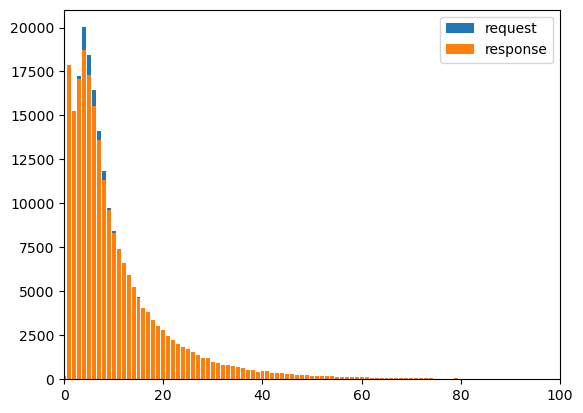

In [9]:
# get the length of each line of the requests and save the occurrences in a dictionary
lengths_request = {}
for sentence in requests:
    length = len(sentence.split())
    if length in lengths_request:
        lengths_request[length] += 1
    else:
        lengths_request[length] = 1

# get the length of each line of the responses and save the occurrences in a dictionary
lengths_response = {}
for sentence in responses:
    length = len(sentence.split())
    if length in lengths_response:
        lengths_response[length] += 1
    else:
        lengths_response[length] = 1

# plot the occurrences of the lengths of the requests and responses in the same plot while only showind x values up to 200
plt.bar(lengths_request.keys(), lengths_request.values(), label="request")
plt.bar(lengths_response.keys(), lengths_response.values(), label="response")
plt.xlim(0, 100)
plt.legend()
plt.show()

Hier werden nun die Daten um die Datenpaare gekürzt, die die gewählte Länge überschreiten.
Zur Überprüfung wird erneut die Länge der beiden Datensätze ausgegeben.

In [10]:
# delete requests and associated responses with length > max_wordcount_in_sentence
requests, responses = dh.removeLongSequences(requests, responses, 1, max_wordcount_in_sentence)

print(f"Länge Fragen: {len(requests)}")
print(f"Länge Antworten: {len(responses)}")


Länge Fragen: 97310
Länge Antworten: 97310


Um den Datensatz noch weiter zu reduzieren, werden die Datensätze basierend auf einer festen Länge gekürzt. Im konkreten Fall konnten wir mit Datensatzgrößen von maximal jeweils ca. 30000 Daten arbeiten, da die Datenmenge sonst nicht in den Arbeitsspeicher passt. 
Außerdem wurden die Daten, welche im Decoder zum Training verwendet werden sollen um Start und End Tokens ergänzt. Dadurch wird der Decoder angewiesen, dass er mit dem Start Token beginnen soll und mit dem End Token aufhören soll.
Basierend auf diesem Tokens können wir das Generieren der Antworten starten und das Predicten ab dem Stop Token beenden.

In [11]:
# limit the size of the dataset
requests = requests[:num_examples]
responses = responses[:num_examples]

# encapsule the responses with the tokens <S> (Start) and <E> (End)
responses = dh.encapsuleWithTokens(responses, '<S>', '<E>')

Nun werden das jeweilige Vorkommen der einzelnen Wörter in Anfragen und Antworten gezählt. Wörter die weniger als 5 mal vorkommen werden dabei herausgefiltert. Schließlich wird die Anzahl der übrigen Wörter bestimmt. +2 um die zusätzlichen Tokens *U* und *P* zu berücksichtigen.

In [12]:
word2count = dh.getWord2Count(requests, responses)

min_wordFrequency = 3
word2count = {k:v for k,v in word2count.items() if v >= min_wordFrequency}
vocab_size = len(word2count)+2
print(f"Anzahl an Wörtern: {vocab_size}")

Anzahl an Wörtern: 5521


Mit Hilfe des Tokenizers können wir nun die vorkommenden Wörter in den Datensätzen mit einem eindeutigen Index versehen und die Datensätze in Sequenzen von Indexen umwandeln. Hierbei bestimmt die Vocab_size die maximal vergebenen Tokens. Hierdurch werden die Wörter mit dem niedrigsten Vorkommen durch den Token *U* (Unknown) ersetzt.
Zur Kontrolle werden die ersten 5 Daten innerhalb der Datensätze vor und nach der Tokenisierung ausgegeben.

In [13]:
oov_token = '<U>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token, filters='', lower=False)

tokenizer.fit_on_texts(requests)
tokenizer.fit_on_texts(responses)
tokenizer.fit_on_texts(["<P>"]) # add padding token to the tokenizer

tokenized_requests = tokenizer.texts_to_sequences(requests)
tokenized_responses = tokenizer.texts_to_sequences(responses)

print(requests[0:5])
print(responses[0:5])
print(tokenized_requests[0:5])
print(tokenized_responses[0:5])

['my room', 'mine too', 'get out of here', 'would you like part of this it is not much', 'like you']
['<S> mine too <E>', '<S> what were they looking for <E>', '<S> it is really that bad <E>', '<S> all the insides are gone <E>', '<S> beautiful <E>']
[[29, 267], [376, 91], [53, 65, 23, 41], [60, 4, 43, 548, 23, 24, 8, 6, 17, 118], [43, 4]]
[[2, 376, 91, 3], [2, 9, 78, 45, 226, 31, 3], [2, 8, 6, 90, 13, 188, 3], [2, 56, 7, 1, 12, 320, 3], [2, 290, 3]]


Um alle Daten auf eine einheitliche Länge zu bringen, werden die Datensätze mit Padding aufgefüllt.
Um die Daten korrekt mit Padding Tokens zu füllen, wird der Index des Padding Tokens ermittelt um ihn anschließend beim Padding zu verwenden.

In [14]:
padding_index = tokenizer.word_index["<P>"]

pad_type = 'post'
trunc_type = 'post'

encoder_input = pad_sequences(tokenized_requests, padding=pad_type, maxlen=max_sentence_length, truncating=trunc_type, value=padding_index)
decoder_input = pad_sequences(tokenized_responses, padding=pad_type, maxlen=max_sentence_length, truncating=trunc_type, value=padding_index)


Weil dem Decoder Ausgaben das Start Token vorangestellt wird, muss das Start Token beim letztendlichen Output der Trainingsdaten des Decoders entfernt werden.
Anschließend wird die Dimension des Outputs erhöht.

In [15]:
vocab_size = len(tokenizer.word_index) + 1

input_encoder_train, input_encoder_val, input_decoder_train, input_decoder_val = train_test_split(encoder_input, decoder_input, test_size=test_size)

output_decoder_train = [i[1:] for i in input_decoder_train]
output_decoder_train = pad_sequences(output_decoder_train, maxlen=max_sentence_length, padding='post', truncating="post", value=padding_index)
output_decoder_train = tf.keras.utils.to_categorical(output_decoder_train, vocab_size)

output_decoder_val = [i[1:] for i in input_decoder_val]
output_decoder_val = pad_sequences(output_decoder_val, maxlen=max_sentence_length, padding='post', truncating="post", value=padding_index)
output_decoder_val = tf.keras.utils.to_categorical(output_decoder_val, vocab_size)

# Model erstellen

Die Parameter des Models wurden im Bereich der Konstanten definiert.

 ## Shared Embedding Layer

Hier wird der Shared Embedding Layer erstellt. Dieser Layer wird sowohl vom Encoder als auch vom Decoder Teil verwendet.

In [16]:
embedding = tf.keras.layers.Embedding(vocab_size, output_dim = outputDimension, trainable=True)

## Encoder
- Input
- Embedding
- LSTM

Hier wird der Encoder Teil des Models erstellt. Er besteht aus einem Input Layer, einem Embedding Layer und einem LSTM Layer.

In [17]:
# input tensor for the encoder, shape of each vector is determined by max_length which was also used to pad the data
inputEncoderTensor = tf.keras.Input(shape=(None, ))

# embedding layer of the encoder, the input is the input tensor, the output is the embedding tensor
encoderEmbedding = embedding(inputEncoderTensor)

# LSTM layer of the encoder, the input is the embedding tensor, the output is the output tensor and the hidden state of the encoder
encoderLSTM = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state = True)
encoderOutput, encoderHiddenState, encoderCellState = encoderLSTM(encoderEmbedding)
encoderStates = [encoderHiddenState, encoderCellState]

## Decoder
- Input
- Embedding
- LSTM
- Dense

Hier wird der Decoder Teil des Models erstellt. Er besteht aus einem Input Layer, einem Embedding Layer, einem LSTM Layer und einem Dense Layer.

In [18]:
# input tensor for the decoder, shape of each vector is determined by max_length which was also used to pad the data
inputDecoderTensor = tf.keras.Input(shape=(None, ))

# embedding layer of the decoder, the input is the input tensor, the output is the embedding tensor
decoderEmbedding = embedding(inputDecoderTensor)

# LSTM layer of the decoder, the input is the embedding tensor and the state of the previous lstm layer, the output is the output tensor and the hidden state of the decoder
decoderLSTM = tf.keras.layers.LSTM(lstm_units, return_state = True, return_sequences=True)
decoderOutput, _, _ = decoderLSTM(decoderEmbedding, initial_state = encoderStates)

# dense layer of the decoder, the input is the output tensor of the lstm layer, the output is the output tensor of the dense layer
# the dense layer has the same number of units as the number of words in the dictionary because the output of the dense layer is a vector with a probability for each word in the dictionary
decoderDense = tf.keras.layers.Dense(vocab_size, activation = "softmax")
outputDense = decoderDense(decoderOutput)

## Summary

Hier wird das Trainingsmodel aus beiden Teilen (Encoder, Decoder) erstellt. Für die Überwachung des Trainingsprozesses kommt die Genauigkeit als Metrik zum Einsatz. Weiterhin wird der Optimizer Adam und die Loss Funktion Categorical Crossentropy verwendet.

In [19]:
if genre == "all":
    # Define the model 
    model = tf.keras.models.Model([inputEncoderTensor, inputDecoderTensor], outputDense)
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # load the base model 
    model = load_model(f"models/model_all.h5")


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 50)     727950      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, None, 400),  721600      ['embedding[0][0]']          

# Trainieren des Models

Um eine Überanpassung des Models zu vermeiden, wird ein Callback erstellt, welches das Training abbricht, wenn die Genauigkeit wärend des Trainings 5 Epochen lang nicht mehr gestiegen ist.
Anschließend wird das Model 200 Epochen lang trainiert.

In [20]:
# generate an early stopping callback to stop training when the validation loss stops improving so that the model doesn't overfit
# waits 3 epochs before stopping
# use val_loss as the metric because categorical_crossentropy calculates the difference between the predicted and actual values and by monitoring wether or not the loss would be decreasing or increasing we can see if the model is improving or not
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', verbose=1, min_delta=0.001, patience=5)

# Train the model on the training data and evaluate it on the validation data
model.fit([input_encoder_train, input_decoder_train], output_decoder_train, epochs=200, callbacks=[earlyStopping])

Epoch 1/200
750/750 [==============================] - 95s 122ms/step - loss: 2.7841 - accuracy: 0.5843
Epoch 2/200
750/750 [==============================] - 87s 115ms/step - loss: 2.3564 - accuracy: 0.6233
Epoch 3/200
750/750 [==============================] - 94s 126ms/step - loss: 2.2299 - accuracy: 0.6333
Epoch 4/200
750/750 [==============================] - 94s 125ms/step - loss: 2.1461 - accuracy: 0.6392
Epoch 5/200
750/750 [==============================] - 87s 116ms/step - loss: 2.0828 - accuracy: 0.6428
Epoch 6/200
750/750 [==============================] - 94s 125ms/step - loss: 2.0271 - accuracy: 0.6458
Epoch 7/200
750/750 [==============================] - 92s 123ms/step - loss: 1.9747 - accuracy: 0.6481
Epoch 8/200
750/750 [==============================] - 89s 119ms/step - loss: 1.9235 - accuracy: 0.6504
Epoch 9/200
750/750 [==============================] - 91s 121ms/step - loss: 1.8724 - accuracy: 0.6521
Epoch 10/200
750/750 [==============================] - 94s 126m

In [21]:
# Evaluate the model on the validation set and store the results

loss = model.evaluate([input_encoder_val, input_decoder_val], output_decoder_val)
print('Test loss:', loss)

188/188 [==============================] - 15s 70ms/step - loss: 5.4765 - accuracy: 0.6028
Test loss: [5.476529121398926, 0.6027500033378601]


# Daten abspeichern

Um das Model später erneut zu laden wird es in einer Datei gespeichert.

In [22]:
model.save(f"models/model_{genre}.h5")

Um die Gewichte des Models später im Interferenzmodel zu verwenden, werden diese in einer Datei gespeichert.

In [23]:
model.save_weights(f"models/weights_{genre}.h5")

Um den Tokenizer später im Interferenzmodel zu verwenden, wird dieser in einer Datei gespeichert.

In [24]:
# save the tokenizer
with open(f"models/tokenizer_{genre}", 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Verwendung des Models

Um das Model zu verwenden muss das run_chatbot.py Script ausgeführt werden. Hier wird mit Hilfe des Interferenzmodells der Chatbot erstellt.

In [25]:
!python run_chatbot.py

Traceback (most recent call last):
  File "c:\Users\noah\source\repos\ML-Projekt\run_chatbot.py", line 17, in <module>
    with open("models/tokenizer_lesswords.pickle", "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: 'models/tokenizer_lesswords.pickle'
